In [1]:
'''
__author__ = 'Alex Cheng'
惩罚线性回归模型 --- K折
Ridge回归通过对回归系数的平方和进行惩罚来避免过拟合(beta的平方和，L2)
其他惩罚项：Lasso(L1), ElasticNet(a)
Lasso的系数向量beta是稀疏的，即对不同的lambda值，许多稀疏等于0,
相比之下Ridge的向量beta是密集的，大部分不等于0

最小角度回归(LARS),可以理解为一种改进的前向逐步回归算法：在引入新属性时只是部分
生成变量重要性排序是惩罚线性回归模型的一个重要特征

Glmnet算法解决ElasticNet问题，包括Lasso(L1)和Ridge(L2),lambda参数觉得惩罚程度
alpha决定L1和L1之间接近程度


本质上，线性方法假设分类以及回归预测可以表示为可用属性的线性组合，
如果有理由怀疑线性模型不够的话，可以通过基扩展使用线性模型来处理非线性问题
基扩展：非线性问题可以通过属性的多项式来近似或者属性的其他非线性函数（比如幂）

'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets,linear_model
from sklearn.metrics import roc_curve,auc
from math import sqrt

In [2]:
target_url = ("http://archive.ics.uci.edu/ml/machine-learning-databases/"
             "undocumented/connectionist-bench/sonar/sonar.all-data")
df = pd.read_csv(target_url,header=None,sep=",",prefix='V')
df.head()

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


In [3]:
# 标签是类别值
print(df.iloc[:,-1].value_counts()) # M:111, R:97
labels = []
for label in df.iloc[:,-1]: # 二分类值转换为实数
    if(label == 'M'):
        labels.append(1.0)
    else:
        labels.append(0.0)

M    111
R     97
Name: V60, dtype: int64


In [4]:
xList  = np.array(df.iloc[:,:-1]) # 属性数组
#labels = [i for i in df.iloc[:,-1]] # 最后一列就是label
names = df.columns

# 正则化columns in x and labels
nrows = len(xList)
ncols = len(xList[0])

# 计算means and variance
xMeans = []
xSD = []
for i in range(ncols):
    col = [xList[j][i] for j in range(nrows)]
    mean = sum(col)/nrows
    xMeans.append(mean)
    colDiff = sum((col - mean) **2)
    
    colDiff2 = [(xList[j,i] - mean) for j in range(nrows) ]
    sumSq = sum([colDiff2[i]  * colDiff2[i] for i in range(nrows)])
    stdDev2 = sqrt(sumSq/nrows)
    
    stdDev = sqrt(colDiff/nrows)
    xSD.append(stdDev)
#print(xMeans,'\n',xSD)
#print(stdDev == stdDev2) # broadcast广播变量的方式，发现结果一样


# 正则化xList
xNorm = []
for i in range(nrows):
    #rowNorm = ([xList[i] - xMeans]) / xSD  #列表不支持
    rowNorm = [(xList[i,j] - xMeans[j]) / xSD[j] for j in range(ncols)]
    xNorm.append(rowNorm)

# 正则化 labels
meanLable = sum(labels)/ nrows
sdLabel = sqrt(sum([ (labels[i] - meanLable) * (labels[i] - meanLable) for i in range(nrows)]) / nrows)
labelNorm = [ (labels[i] - meanLable) / sdLabel for i in range(nrows) ]

In [16]:
# 定义测试和训练的属性和列表
nxval = 10 # 几折采样

# 无需normalized的从datafram中采样
#indices = len(df)
#xTrain = np.array(df[df.index % 3 != 0].iloc[:,:-1]) # dataframe转为numpy数组
#yTrain = [labels[i] for i in df.index if i%3 !=0]
#xTest =  np.array(df[df.index % 3 == 0].iloc[:,:-1])
#yTest = [labels[i] for i in df.index if i%3 ==0]

# 需要normalized的从list中采样

idxTest =  [i for i in range(nrows) if i % nxval ==0]
idxTrain = [i for i in range(nrows) if i % nxval !=0]
xTrain = [xNorm[r] for r in idxTrain]
xTest  = [xNorm[r] for r in idxTest]
yTrain = [labelNorm[r] for r in idxTrain]
yTest  = [labelNorm[r] for r in idxTest]
nrowsTrain = len(xTrain)


['V10', 'V48', 'V44', 'V51', 'V11', 'V20', 'V21', 'V3', 'V27', 'V45', 'V22', 'V0', 'V28', 'V53', 'V19', 'V26', 'V58', 'V23']


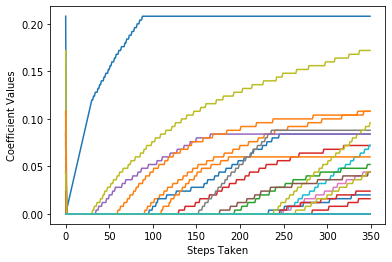

In [18]:
# LARS 对分类问题
# 初始化 coefficients beta 向量
beta = [0.0] * ncols
betaMat = []
betaMat.append(beta)

# number of steps to take
steps = 350
stepSize = 0.004
nzList = [] # 记录非零的系数


for step in range(steps):
    #residuals = [0.0] * nrows # 全体记录数
    residuals = [0.0] * nrowsTrain # 采样记录数
    #for j in range(nrows): # 计算训练集的预测的残差
    for j in range(nrowsTrain): # 计算训练集的预测的残差
        labelsHat = sum([xTrain[j][k] * beta[k] for k in range(ncols)])
        residuals[j] = yTrain[j] - labelsHat
    
    # 计算每个列（属性）和残差的相关性
    corr = [0.0] * ncols
    for j in range(ncols):
        corr[j] = sum([xTrain[k][j] * residuals[k] for k \
                       in range(nrowsTrain)]) / nrowsTrain
    
    iStart = 0
    corrStart = corr[0]
    for j in range(1,ncols): #找绝对值最大的系数
        if abs(corrStart) < corr[j]:
            iStart = j; corrStart = corr[j]
            
    beta[iStart] += stepSize * corrStart / abs(corrStart) # 对应beta值增加
    betaMat.append(list(beta)) # 这个步骤的beta系数
    
    # 非零的系数
    nzBeta = [index for index in range(ncols) if beta[index] != 0]
    for q in nzBeta:
        if (q in nzList) == False: # 只记录首次出现的系数
            nzList.append(q)

nameList = [names[nzList[i]] for i in range(len(nzList))]
print(nameList)

for i in range(ncols):
    # 对应每个属性，画出beta 值的范围
    coefCurve = [betaMat[k][i] for k in range(steps)]
    xaxis = range(steps)
    plt.plot(xaxis, coefCurve)
    
plt.xlabel("Steps Taken")
plt.ylabel("Coefficient Values")
plt.show()

    